# Homework 2

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import hw2_utils as u

from scipy.optimize import minimize
from tqdm.auto import tqdm

In [2]:
# Load the data
with open("hw2_data.pkl", "rb") as f:
    data = pickle.load(f).T  # check out that pesky little `.T`
print(data.shape)

t_i = data[0]
sigma_i = data[1]
dataset = data[2:]

(13, 1024)


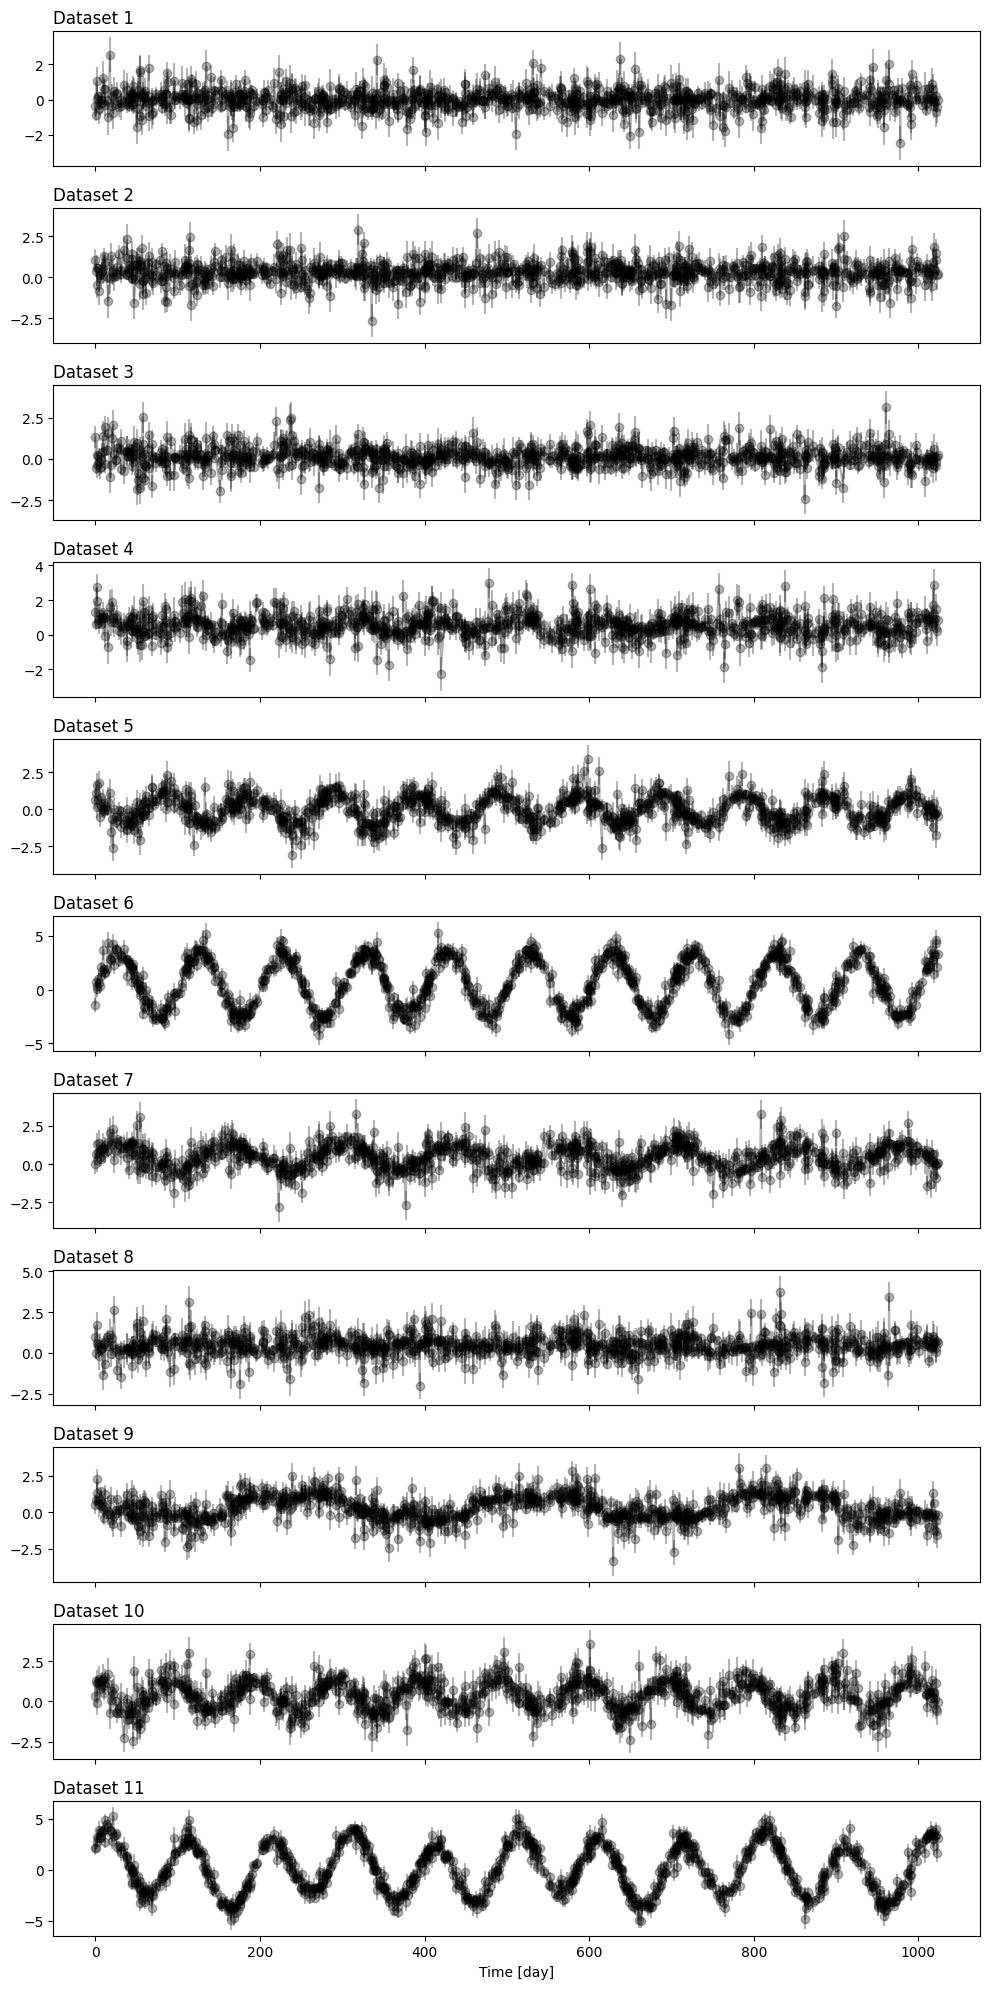

In [3]:
def plot_data():
    fig, axs = plt.subplots(11, 1, figsize=(10, 20), sharex=True)
    for i in range(dataset.shape[0]):
        axs[i].errorbar(t_i, dataset[i], yerr=sigma_i, color="k", marker="o", alpha=0.3, zorder=0)
        axs[i].set_title(f"Dataset {i+1}", loc='left')
    axs[-1].set_xlabel("Time [day]")
    fig.tight_layout()
    return fig, axs

plot_data();

# Step 1: Measure all signals with a period of 100 days

In this part, we're looking in all the datasets for a signal with a period of 100 days. Such a signal could be represented by the model 
$$ y_i = D + A \sin(2\pi t_i/T_0 + \phi) + \text{noise}, $$
where $T_0$ is 100 days. The model has free parameters $A$ (amplitude), $\phi$ (phase), and D (DC level). We seek to measure $A$.

In an effort to remove the nonlinear parameter $\phi$, we reparameterize the model as follows:
$$ y_i = D + A_1 \sin(2\pi t_i/T_0) + A_2 \cos(2\pi t_i/T_0) + \text{noise}, $$
where $A, \phi$ have been traded for $A_1, A_2$.

For a given point $i$, we can represent the model prediction as $y_i - \text{noise}$, e.g.
$$ \mu_i = D + A_1 \sin(2\pi t_i/T_0) + A_2 \cos(2\pi t_i/T_0). $$

Then, we can write down the following (log-)likelihood function.
$$ \mathcal{L} = -\frac{1}{2} \sum_{i} \frac{(y_i - \mu_i(\theta))^2}{\sigma_i^2}, $$
where $\theta$ represents our model parameters $\{ D, A_1, A_2 \}$.

We can maximize the log-likelihood (or equivalently minimize the _negative_ of the log-likelihood) to find the best-fit values of the parameters. This is great, but it still does not tell us whether we have actually _detected_ a signal. To do this, we'll use **likelihood ratios** to compare our sinusoid model to the null model. Our null model is defined as $\mu_i^{\emptyset} = D$, e.g. _only_ a DC level. 

We define the likelihood ratio $\Lambda$ as 
$$ \Lambda \equiv \frac{L_\emptyset(\theta)}{L(\theta)} = \exp \big[ \log L_\emptyset(\theta) - \log L(\theta) \big]. $$
Alternatively, we can look at the logarithm of this ratio:
$$ \lambda = \log \Lambda = \log L_\emptyset(\theta) - \log L(\theta). $$

We will claim that we have detected a signal when $\lambda$ exceeds a given threshold. Naïvely, we see that $\lambda < 0$ when the presence of a signal is more likely than the null, but this is not sufficient for significance. Instead, we want to estimate the sampling error $\sigma_\lambda$ on this statistic using bootstrapping. Then, we'll only claim we've detected the sinusoid (of period 100 days) if $\lambda$ differs from $0$ by more than $3 \sigma_\lambda$.

In [4]:
one_signal = []

for index, y_i in enumerate(dataset):
    data = (t_i, y_i, sigma_i)
    
    fit, logl = u.max_likelihood_estimate(u.one_signal_model, [0, 1, 1], data)
    null_fit, null_logl = u.max_likelihood_estimate(u.null_model, [0], data)
    
    llr = null_logl - logl
    
    def _llr_func(resampled_data):
        """using our best fits, recompute the logl difference on the resampled data"""
        logl_1 = u.logl(fit, u.one_signal_model, resampled_data)
        logl_0 = u.logl(null_fit, u.null_model, resampled_data)
        return logl_0 - logl_1
    
    llr_err = u.bootstrap(data, _llr_func, llr)
    
    amp = np.sqrt(fit[1]**2 + fit[2]**2)
    
    def _amp_func(resampled_data):
        """re-do the fit and compute the amplitude on the resampled data"""
        _fit, _logl = u.max_likelihood_estimate(u.one_signal_model, [0, 1, 1], resampled_data)
        return np.sqrt(_fit[1]**2 + _fit[2]**2)
    
    amp_err = u.bootstrap(data, _amp_func, amp)
    
    one_signal.append({
        'fit': fit,
        'logl': logl,
        'null_fit': null_fit,
        'null_logl': null_logl,
        'llr': llr,
        'llr_err': llr_err.item(),
        'amp': amp,
        'amp_err': amp_err.item(),
    })

one_signal = pd.DataFrame(one_signal)

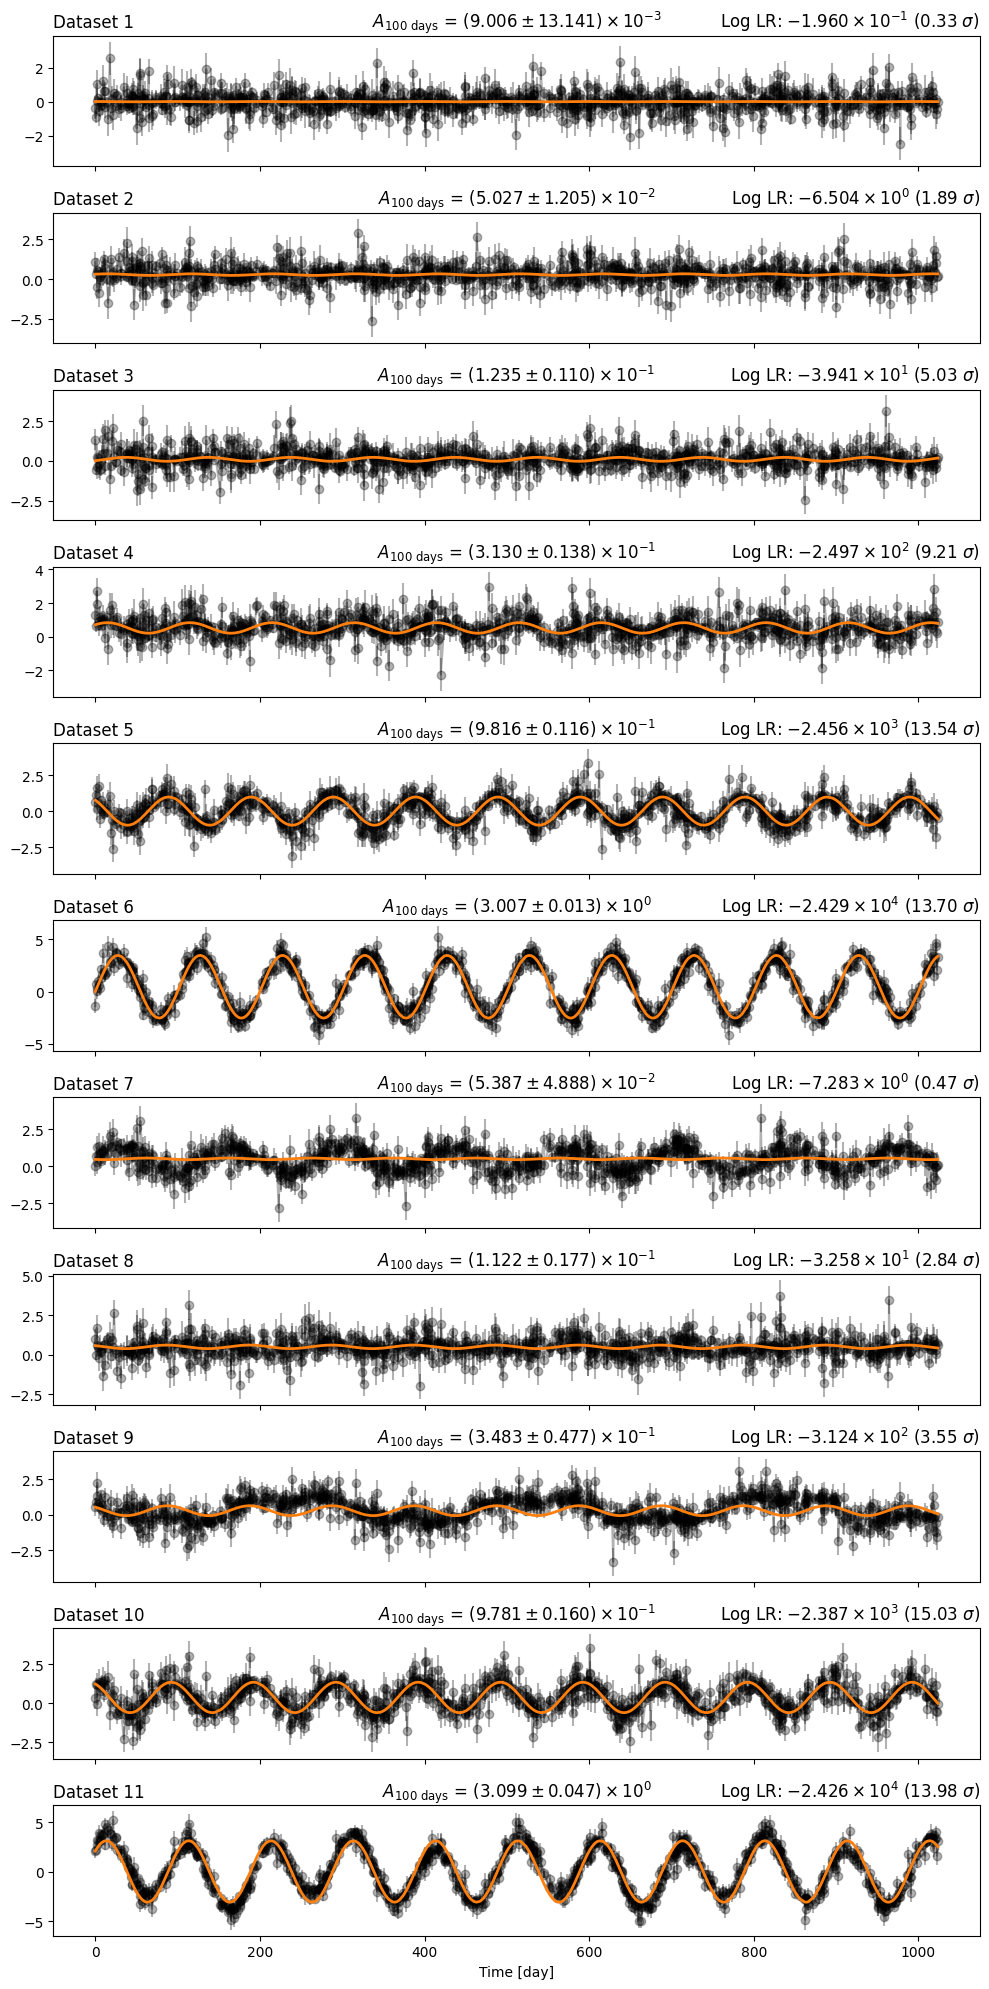

In [5]:
fig, axs = plot_data()

for i in range(dataset.shape[0]):
    res = one_signal.iloc[i]  # Results for this dataset
    axs[i].plot(t_i, u.one_signal_model(res.fit, t_i), color="C1", lw=2, alpha=1, zorder=1)
    axs[i].set_title("$A_{ 100 \\ \\mathrm{days} }$ = " + f"{u.latex_float(res.amp, res.amp_err)}")
    axs[i].set_title(f"Log LR: {u.latex_float(res.llr)} ({abs(res.llr) / res.llr_err:.2f} $\\sigma$)", loc='right')

fig.tight_layout()
plt.show()

In [6]:
print(
    "We were able to detect the 100-day sinusoid to 3 sigma in datasets "
    + ", ".join([ f"{i+1}" for i, res in one_signal.iterrows() if abs(res.llr) / res.llr_err >= 3 ])
)
print()
print("The measured amplitudes (with errors) are as given as follows:")
for i, res in one_signal.iterrows():
    if abs(res.llr) / res.llr_err >= 3:
        print(f"    Dataset {i+1:02d}: {res.amp:.2e} ± {res.amp_err:.2e}")
    else:
        print(f"    Dataset {i+1:02d}: not detected")

We were able to detect the 100-day sinusoid to 3 sigma in datasets 3, 4, 5, 6, 9, 10, 11

The measured amplitudes (with errors) are as given as follows:
    Dataset 01: not detected
    Dataset 02: not detected
    Dataset 03: 1.24e-01 ± 1.10e-02
    Dataset 04: 3.13e-01 ± 1.38e-02
    Dataset 05: 9.82e-01 ± 1.16e-02
    Dataset 06: 3.01e+00 ± 1.33e-02
    Dataset 07: not detected
    Dataset 08: not detected
    Dataset 09: 3.48e-01 ± 4.77e-02
    Dataset 10: 9.78e-01 ± 1.60e-02
    Dataset 11: 3.10e+00 ± 4.69e-02


# Step 2: Look for other signals

Supposedly, 10 of the 11 datasets have a 100-day signal (though we did not confidently detect all of them), and 5 of _these_ have _another_ signal of unknown period. Let's look for these. However, since we don't know the period, we'll have to search over many values of the period and try to determine which has the largest likelihood.

The maximum frequency that can be detected in evenly spaced time data is given by the Nyquist frequency, e.g. half the sampling frequency. Our time data is _not_ evenly spaced, but we can take the reciprocal of the time bin widths to get approximations of the instantaneous sampling frequencies. We want to take a middling estimate of the instantaneous sampling frequency to compute the Nyquist frequency, so we choose to use the median. Too high an estimate of the Nyquist frequency means that our grid search will extend up to significantly higher frequencies than are even really detectable (since much of the data is at too low a sampling frequency).

The minimum difference between frequencies that we can resolve is on the order of the reciprocal of the total time in the dataset (1024 days). To be conservative, we'll choose to halve this minimum to use as our bin size for our frequency grid search.

As such, we'll conduct a grid search over frequencies between zero and half the median sampling frequency in bins that are 1/(2048 days) wide.

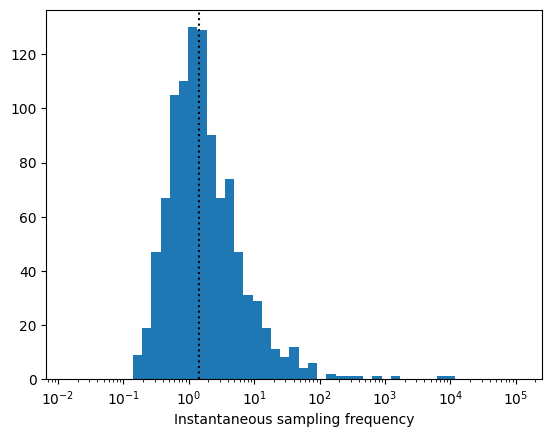

1485 frequencies to scan


In [7]:
def compute_freq_grid(t_i):
    freqs = 1 / np.diff(t_i)
    plt.hist(freqs, bins=np.geomspace(freqs.min() * .1, freqs.max() * 10, 50))
    plt.axvline(np.median(freqs), ls=':', color='k')
    plt.xscale('log')
    plt.xlabel('Instantaneous sampling frequency')
    plt.show()

    max_f = 0.5 * np.median(freqs)  # approx Nyquist
    f_width = 1 / 2048
    freq_grid = np.arange(0, max_f + f_width/2, step=f_width)
    return freq_grid

freq_grid = compute_freq_grid(t_i)
print(f"{len(freq_grid)} frequencies to scan")

For each frequency, we want to find the best fit (for the DC level and signal amplitudes) and save out the log-likelihood. This will let us find the best-fit frequencies.

In [8]:
freq_search_logls = np.zeros((len(dataset), len(freq_grid)))

for i, y_i in enumerate(tqdm(dataset, desc="Testing frequencies", unit="dataset")):
    data = (t_i, y_i, sigma_i)
    
    for j, freq in enumerate(freq_grid):
        _, logl = u.max_likelihood_estimate_profile(u.two_signal_model, [0, 1, 1, 1, 1], [freq], data)
        freq_search_logls[i, j] = logl

Testing frequencies:   0%|          | 0/11 [00:00<?, ?dataset/s]

We can see pretty clearly in a few of these plots a narrow frequency band that has a _significantly_ higher log-likelihood than the baseline 'noise' level, so we expect these datasets to have a second signal with a frequency around that band. How do we conclude when we've successfully detected a second signal, though? And what frequency do we choose to use?

Let's answer the second question first. To find the best-fit frequency, we're going to find the maximum log-likelihood observed and fit a parabola to this point and its two neighbors. Then, we'll take the position of the vertex of this parabola as our frequency.

Now for the first question. We can extend our likelihood ratio method in this case. However, now our null model must be somewhat more complicated. I believe that to convincingly show we have detected the second signal, we need to show that it is statistically significantly more likely than _both_ the zero signal and 100-day signal models. To do this, I think we should compute the following likelihood ratio, where the effective null model likelihood is now the sum of the likelihoods from the zero-signal and 100-day signal models.

$$ \frac{ L(\text{zero signal}) + L(\text{100 day signal}) }{ L(\text{two signals}) } $$

I can't get this to work, though; when $L(\text{two signals}) \gg L(\text{zero signal}), L(\text{100 day signal})$, computing this quantity easily overflows. I tried a few different tricks for reducing the arguments to `exp`, but unfortunately none could solve it for me altogether.

Barring a solution to the above computation, I think the best thing to do it is to compare the two signal model to each of the zero signal and 100-day signal models independently, and declare that we've detected the second signal whenever we have a $3\sigma$ log-likelihood difference for _both_.

In [9]:
def parabola_vertex(x, y):
    """return the vertex of the parabola through the points (x, y)
    NOTE: please only give me three points"""
    
    X = np.array([[_x**2, _x, 1] for _x in x])
    y = np.reshape(y, (-1, 1))
    
    theta = np.linalg.solve(X, y)
    a, b, c = theta[:, 0]
    # parabola is ax^2 + bx + c, exactly passes through all three points
    return -0.5 * b / a, c - 0.25 * b**2 / a


two_signal = []

for i, y_i in enumerate(tqdm(dataset, desc="Bootstrapping...", unit="dataset")):
    data = (t_i, y_i, sigma_i)
    
    # find best frequency
    index = np.argmax( freq_search_logls[i, :] )
    coords = slice(index - 1, index + 2)
    freq, _ = parabola_vertex(freq_grid[coords], freq_search_logls[i, coords])
    
    # find max likelihood estimates for each of the three models
    # (use the specific frequency we just found for our two signal model)
    fit_2, logl_2 = u.max_likelihood_estimate_profile(u.two_signal_model, [0, 1, 1, 1, 1], [freq], data)
    fit_1, logl_1 = one_signal.iloc[i]['fit'], one_signal.iloc[i]['logl']
    fit_0, logl_0 = one_signal.iloc[i]['null_fit'], one_signal.iloc[i]['null_logl']
    
    # compute likelihood ratios and error
    llr = np.array([ logl_0 - logl_2, logl_1 - logl_2 ])
    
    def _llr_func(resampled_data):
        """using our best fits, recompute the logl differences on the resampled data"""
        logl_2 = u.logl_profile(fit_2, [freq], u.two_signal_model, resampled_data)
        logl_1 = u.logl(fit_1, u.one_signal_model, resampled_data)
        logl_0 = u.logl(fit_0, u.null_model, resampled_data)
        return np.array([ logl_0 - logl_2, logl_1 - logl_2 ])
    
    llr_err = u.bootstrap(data, _llr_func, llr)
    
    # compute amplitudes and error
    amp = np.sqrt(np.array([fit_2[1]**2 + fit_2[2]**2, fit_2[3]**2 + fit_2[4]**2]))
    
    def _amp_func(resampled_data):
        """re-do the fit and compute the amplitude on the resampled data"""
        _fit, _ = u.max_likelihood_estimate_profile(
            u.two_signal_model, [0, 1, 1, 1, 1], [freq], resampled_data
        )
        return np.sqrt(np.array([_fit[1]**2 + _fit[2]**2, _fit[3]**2 + _fit[4]**2]))
    
    amp_err = u.bootstrap(data, _amp_func, amp)
    
    two_signal.append({
        'freq': freq,
        'fit': fit_2,
        'logl': logl_2,
        'llr': llr,
        'llr_err': llr_err,
        'amp': amp,
        'amp_err': amp_err,
    })
    
two_signal = pd.DataFrame(two_signal)

Bootstrapping...:   0%|          | 0/11 [00:00<?, ?dataset/s]

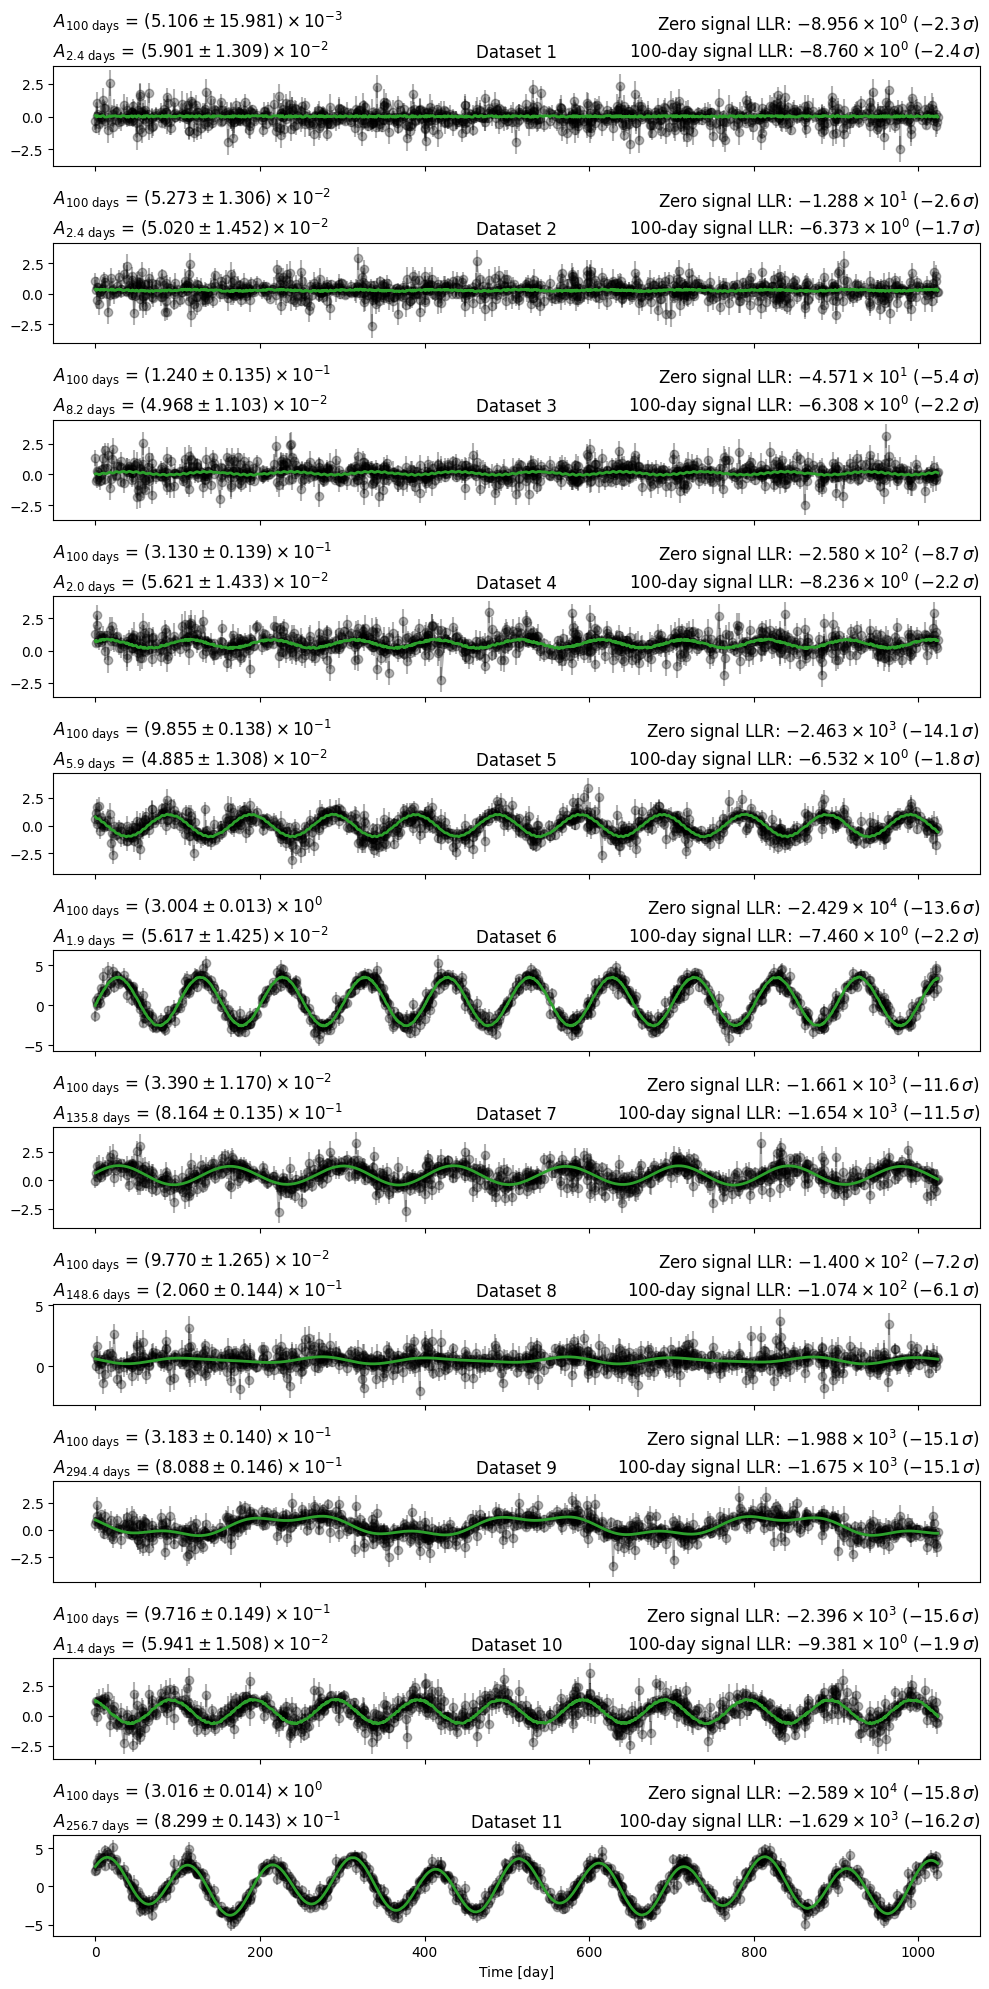

In [10]:
def amp_title(period, amp, amp_err):
    return "$A_{ " + period + " \\ \\mathrm{days} }$ = " + u.latex_float(amp, amp_err)

def llr_title(label, llr, llr_err):
    return f"{label} LLR: {u.latex_float(llr)} (${llr / llr_err:.1f} \\, \\sigma$)"


fig, axs = plot_data()

for i in range(dataset.shape[0]):
    res = two_signal.iloc[i]  # Results for this dataset
    axs[i].plot(t_i, u.two_signal_model((*res.fit, res.freq), t_i), color="C2", lw=2, alpha=1, zorder=1)
    
    amp1_title = amp_title("100", res.amp[0], res.amp_err[0])
    amp2_title = amp_title(f"{1 / res.freq:.1f}", res.amp[1], res.amp_err[1])
    axs[i].set_title(f"{amp1_title}\n{amp2_title}", loc='left')
    
    axs[i].set_title(f"Dataset {i+1}", loc='center')
    
    llr0_title = llr_title("Zero signal", res.llr[0], res.llr_err[0])
    llr1_title = llr_title("100-day signal", res.llr[1], res.llr_err[1])
    axs[i].set_title(f"{llr0_title}\n{llr1_title}", loc='right')

fig.tight_layout()
plt.show()

In [11]:
print(
    "We were able to detect two sinusoids to 3 sigma in datasets "
    + ", ".join([ f"{i+1}" for i, res in two_signal.iterrows() if abs((res.llr / res.llr_err)).min() >= 3 ])
)
print()
print("The measured amplitudes (with errors) are as given as follows:")
for i, res in two_signal.iterrows():
    if abs((res.llr / res.llr_err)).min() >= 3:
        print(f"    Dataset {i+1:02d}")
        print(f"        100 day signal:  \t{res.amp[0]:.2e} ± {res.amp_err[0]:.2e}")
        print(f"        {1 / res.freq:.1f} day signal:\t{res.amp[1]:.2e} ± {res.amp_err[1]:.2e}")
    else:
        print(f"    Dataset {i+1:02d}: not detected")

We were able to detect two sinusoids to 3 sigma in datasets 7, 8, 9, 11

The measured amplitudes (with errors) are as given as follows:
    Dataset 01: not detected
    Dataset 02: not detected
    Dataset 03: not detected
    Dataset 04: not detected
    Dataset 05: not detected
    Dataset 06: not detected
    Dataset 07
        100 day signal:  	3.39e-02 ± 1.17e-02
        135.8 day signal:	8.16e-01 ± 1.35e-02
    Dataset 08
        100 day signal:  	9.77e-02 ± 1.26e-02
        148.6 day signal:	2.06e-01 ± 1.44e-02
    Dataset 09
        100 day signal:  	3.18e-01 ± 1.40e-02
        294.4 day signal:	8.09e-01 ± 1.46e-02
    Dataset 10: not detected
    Dataset 11
        100 day signal:  	3.02e+00 ± 1.38e-02
        256.7 day signal:	8.30e-01 ± 1.43e-02


# Repeating our 100-day signal amplitude measurements using our knowledge of the second signal

Now we want to repeat our fits on the 100-day signal _alone_ using the best-fit amplitude for the second signal and measure the amplitude of the first signal.

In [12]:
one_signal_repeat = []

for i, y_i in enumerate(dataset):
    data = (t_i, y_i, sigma_i)
    
    # only continue if both two signal LLRs are > 3 sigma
    res = two_signal.iloc[i]  # two signal result
    if np.abs(res.llr / res.llr_err).min() > 3:
        
        # re-do the fit, fixing the second signal's parameters
        prof_params = [ *res.fit[3:], res.freq ]
        fit, logl = u.max_likelihood_estimate_profile(u.two_signal_model, [0, 1, 1], prof_params, data)
        
        # measure amplitude and error
        amp = np.sqrt(fit[1]**2 + fit[2]**2)

        def _amp_func(resampled_data):
            """re-do the fit and compute the amplitude on the resampled data"""
            _fit, _ = u.max_likelihood_estimate_profile(
                u.two_signal_model, [0, 1, 1], prof_params, resampled_data
            )
            return np.sqrt(_fit[1]**2 + _fit[2]**2)

        amp_err = u.bootstrap(data, _amp_func, amp)
        
        one_signal_repeat.append({
            'index': i,
            'fit': fit,
            'logl': logl,
            'amp': amp,
            'amp_err': amp_err.item(),
        })
        
one_signal_repeat = pd.DataFrame(one_signal_repeat).set_index("index")

In [13]:
row_fmt = "{: <12}| {: <24}| {: <24}"

print(row_fmt.format("", "New", "Old"))

for i, res in one_signal_repeat.iterrows():
    old_res = one_signal.iloc[i]
    print(row_fmt.format(
        f"Dataset {i+1}",
        f"{res.amp:.3e} ± {res.amp_err:.3e}",
        f"{old_res.amp:.3e} ± {old_res.amp_err:.3e}",
    ))

            | New                     | Old                     
Dataset 7   | 3.393e-02 ± 1.219e-02   | 5.387e-02 ± 4.888e-02   
Dataset 8   | 9.778e-02 ± 1.487e-02   | 1.122e-01 ± 1.768e-02   
Dataset 9   | 3.183e-01 ± 1.321e-02   | 3.483e-01 ± 4.766e-02   
Dataset 11  | 3.016e+00 ± 1.395e-02   | 3.099e+00 ± 4.690e-02   


We can see that when we include our knowledge of the best fit for the second signal, we obtain a smaller measurement of the 100-day signal amplitude with smaller error in every case. For dataset 7, this difference is rather large. This makes sense, because dataset 7 is _dominated_ by the second signal, so the 100-day signal fit fails when we don't account for the second signal. When we account for it by including the best fit for the second signal, we can more accurately measure the _small_ contribution from the 100-day signal. The same logic largely applies for the other three datasets, though the effect is smaller as the second signal is not nearly as dominant in these cases.

# Summary: plots of the best fits

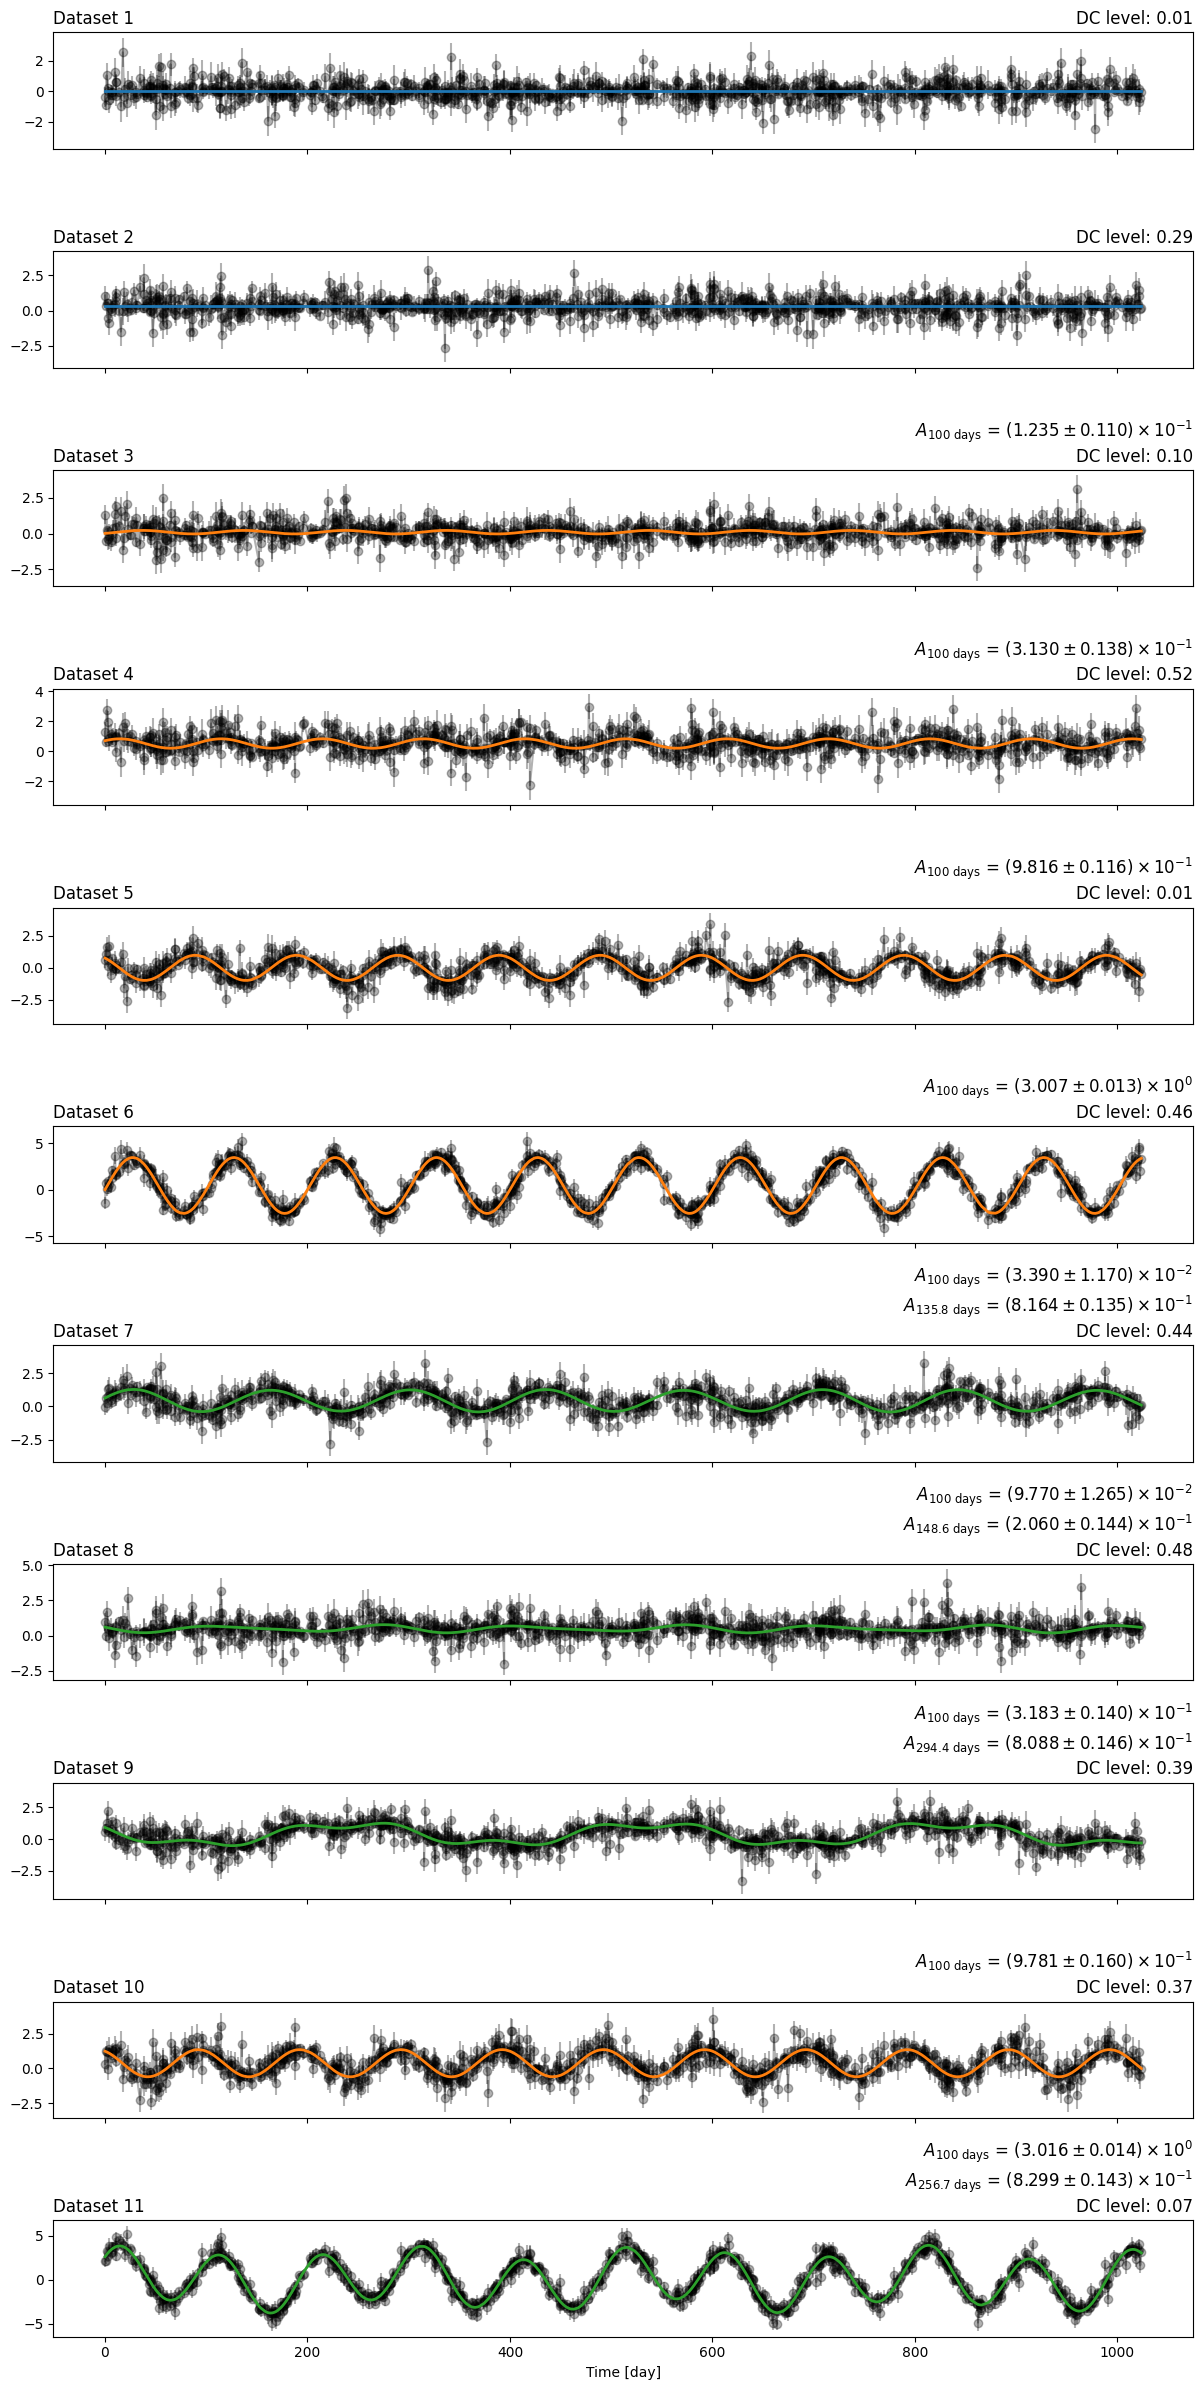

In [14]:
fig, axs = plt.subplots(11, 1, figsize=(12, 24), sharex=True)
for i in range(dataset.shape[0]):
    axs[i].errorbar(t_i, dataset[i], yerr=sigma_i, color="k", marker="o", alpha=0.3, zorder=0)
    
    two_sig_res = two_signal.iloc[i]
    one_sig_res = one_signal.iloc[i]
    
    if abs((two_sig_res.llr / two_sig_res.llr_err)).min() >= 3:
        res = two_sig_res
        axs[i].plot(t_i, u.two_signal_model((*res.fit, res.freq), t_i), color="C2", lw=2, alpha=1, zorder=1)
        
        amp1_title = amp_title("100", res.amp[0], res.amp_err[0])
        amp2_title = amp_title(f"{1 / res.freq:.1f}", res.amp[1], res.amp_err[1])
        axs[i].set_title(f"{amp1_title}\n{amp2_title}\nDC level: {res.fit[0]:.2f}", loc='right')
        
    elif abs(one_sig_res.llr / one_sig_res.llr_err) >= 3:
        res = one_sig_res
        axs[i].plot(t_i, u.one_signal_model(res.fit, t_i), color="C1", lw=2, alpha=1, zorder=1)
        axs[i].set_title(f"{amp_title('100', res.amp, res.amp_err)}\nDC level: {res.fit[0]:.2f}", loc='right')
        
    else:
        res = one_sig_res
        axs[i].plot(t_i, u.null_model(res.null_fit, t_i), color="C0", lw=2, alpha=1, zorder=1)
        axs[i].set_title(f"DC level: {res.null_fit[0]:.2f}", loc='right')
    
    axs[i].set_title(f"Dataset {i+1}", loc='left')
axs[-1].set_xlabel("Time [day]")
fig.tight_layout()